In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from tensorflow.python.ops.numpy_ops import np_config

2023-07-18 14:44:09.471420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 14:44:09.549454: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 14:44:09.895278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vishesh/anaconda3/lib/:/home/vishesh/anaconda3/lib/python3.9/site-packages/nvidi

In [2]:
model = tf.keras.models.load_model("/home/vishesh/Desktop/datasets/ships-data/Xception-10-0.74.hdf5", compile=False)
model.compile(optimizer=tfa.optimizers.RectifiedAdam(), loss='categorical_crossentropy')

feature_extractor = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('dense_1').output)

2023-07-18 14:44:12.578026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 14:44:12.596285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 14:44:12.596822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 14:44:12.598639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 14:44:12.599204: I tensorflow/compiler/xla/stream_executo

In [3]:
train_data_dir = "/home/vishesh/Desktop/datasets/ships-data/X_true_train_240_320"
train_ground_truth_dir = "/home/vishesh/Desktop/datasets/ships-data/Y_true_train_240_320"

test_data_path = "/home/vishesh/Desktop/datasets/ships-data/X_true_val_240_320/1.npy"
test_ground_truth_path = "/home/vishesh/Desktop/datasets/ships-data/Y_true_val_240_320/1.npy"

perturbation = "brightness"
strength = 7
perturbed_dataset_path = f"/home/vishesh/Desktop/datasets/ships-data/perturbed_test/varying/{perturbation}/{strength}/1.npy"

In [4]:
X_train = None
y_train = None


for i in range(1,11):
    print(i)
    input_data_path = os.path.join(train_data_dir, f"{i}.npy")
    ground_truth_path = os.path.join(train_ground_truth_dir, f"{i}.npy")
    
    if i == 1:
        X_train = np.load(input_data_path)
        y_train = np.load(ground_truth_path)
        continue
        
        
    new_input_data = np.load(input_data_path)
    new_ground_truth = np.load(ground_truth_path)
    

    X_train = np.vstack((X_train, new_input_data))
    y_train = np.hstack((y_train, new_ground_truth))
    
y_train = y_train.astype(int)

1
2
3
4
5
6
7
8
9
10


In [5]:
X_test = np.load(test_data_path)
y_test = np.load(test_ground_truth_path).astype(int)

perturbed_dataset = np.load(perturbed_dataset_path)
X_test[-200:] = perturbed_dataset[-200:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10000, 240, 320, 3) (10000,) (1000, 240, 320, 3) (1000,)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split

from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues

/home/vishesh/anaconda3/envs/alibidetect/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
txt_classes = {0: "Carrier", 
               1: "CombatVessel", 
               2: "Container", 
               3: "Passenger", 
               4: "Ro-ro", 
               5: "Tanker", 
               6: "Tug", 
               7: "Vessel", 
               8: "Yacht"}

def plot_images(X_full, y_full, show_labels=True):
    plt.rcParams["figure.figsize"] = (9,7)
    for i in range(15):
        X,y = X_full[i], y_full[i]
        ax = plt.subplot(3,5,i+1)
        if show_labels:
            ax.set_title(txt_classes[int(y)])
        ax.imshow(X[:,:,::-1])
        ax.axis('off')
    plt.show()

def visualize_outliers(idxs, X_full, y_full):
    plot_images(X_full[idxs], y_full[idxs])

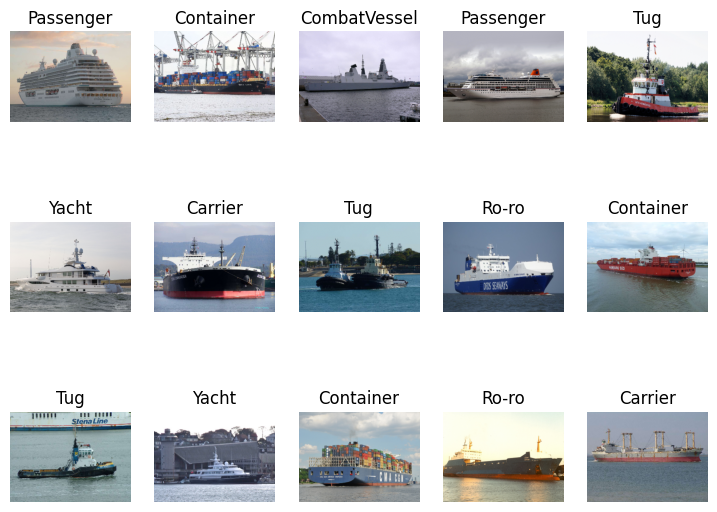

In [8]:
plot_images(X_train, y_train, show_labels=True)

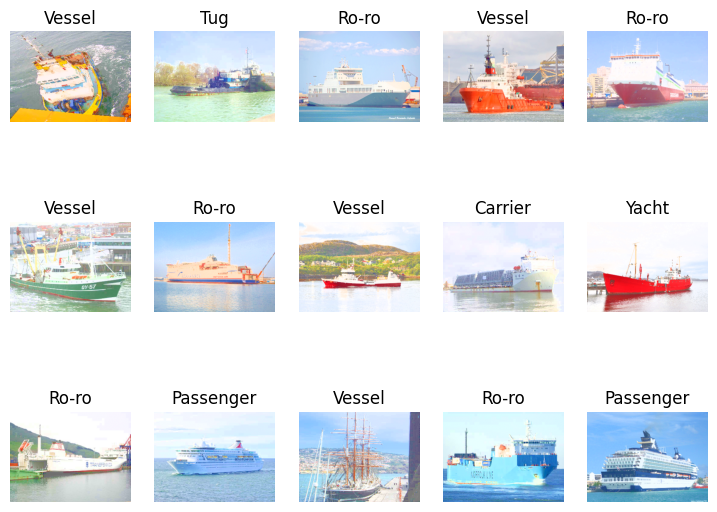

In [9]:
plot_images(X_test[800:], y_test[800:], show_labels=True)

In [10]:
train_feature_embeddings = feature_extractor.predict(X_train, batch_size=32)
test_feature_embeddings = feature_extractor.predict(X_test, batch_size=32)

print(f'Train embeddings pooled shape: {train_feature_embeddings.shape}')
print(f'Test embeddings pooled shape: {test_feature_embeddings.shape}')

2023-07-18 14:45:14.935880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-07-18 14:45:16.141514: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-18 14:45:16.141538: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-18 14:45:16.433228: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

  1/313 [..............................] - ETA: 13:51

2023-07-18 14:45:16.649616: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-18 14:45:16.649641: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-18 14:45:16.731038: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.88GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-18 14:45:16.731055: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

312/313 [============================>.] - ETA: 0s

2023-07-18 14:45:45.224587: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-18 14:45:45.224607: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


32/32 [==============================] - 3s 102ms/step
Train embeddings pooled shape: (10000, 1024)
Test embeddings pooled shape: (1000, 1024)


In [11]:
ood = OutOfDistribution()
train_ood_features_scores = ood.fit_score(features=train_feature_embeddings)

# top_train_ood_features_idxs = find_top_issues(quality_scores=train_ood_features_scores, top=15)
# visualize_outliers(top_train_ood_features_idxs, X_train, y_train)

Fitting OOD estimator based on provided features ...


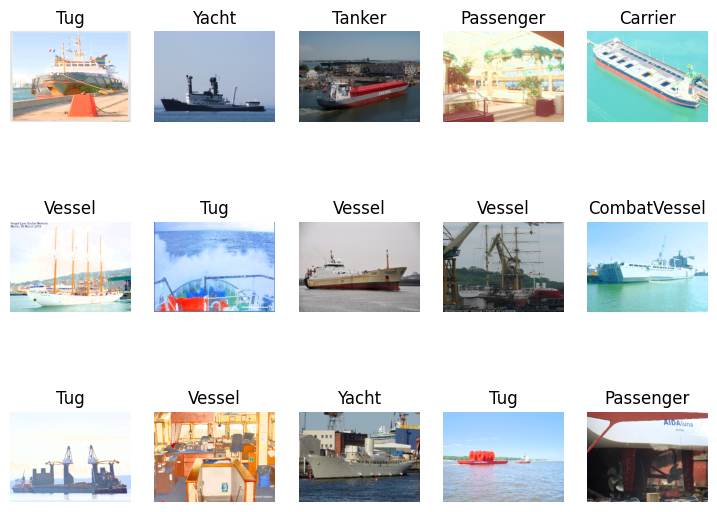

In [12]:
test_ood_features_scores = ood.score(features=test_feature_embeddings)

top_ood_features_idxs = find_top_issues(test_ood_features_scores, top=15)
visualize_outliers(top_ood_features_idxs, X_test, y_test)

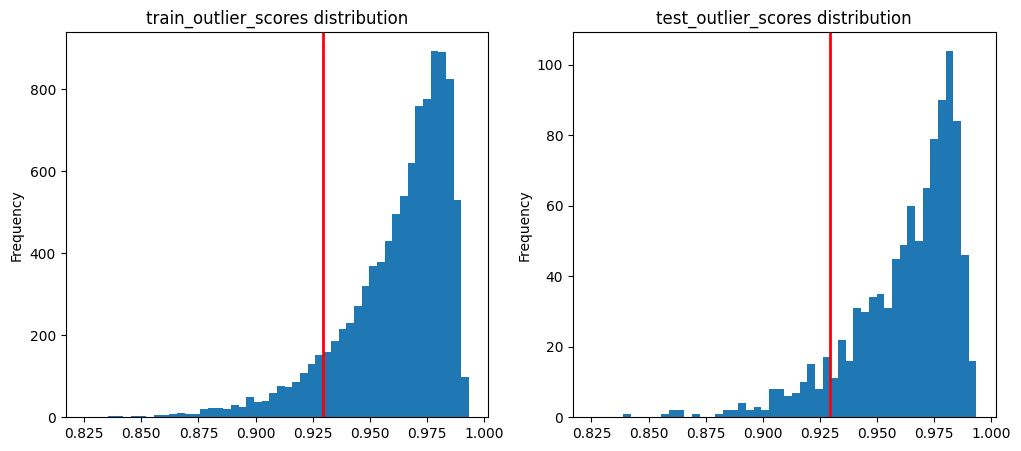

In [13]:
tenth_percentile = np.percentile(train_ood_features_scores, 10)  # 10th percentile of the train_data distribution

# Plot outlier_score distributions and the 5th percentile cutoff
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt_range = [min(train_ood_features_scores.min(),test_ood_features_scores.min()), \
             max(train_ood_features_scores.max(),test_ood_features_scores.max())]
axes[0].hist(train_ood_features_scores, range=plt_range, bins=50)
axes[0].set(title='train_outlier_scores distribution', ylabel='Frequency')
axes[0].axvline(x=tenth_percentile, color='red', linewidth=2)
axes[1].hist(test_ood_features_scores, range=plt_range, bins=50)
axes[1].set(title='test_outlier_scores distribution', ylabel='Frequency')
axes[1].axvline(x=tenth_percentile, color='red', linewidth=2)

plt.show()

In [14]:
thresh = tenth_percentile
test_ood_features_scores[800:][test_ood_features_scores[800:] < thresh].shape[0] / 200 # True positives

0.2

In [15]:
test_ood_features_scores[:800][test_ood_features_scores[:800] < thresh].shape[0] / 800 # False positives

0.075